# Лабораторная работа №1
## Поэлементные преобразования изображений

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

1. Считать цветное rgb изображение

In [2]:
img = cv2.imread("index.png")

2. Преобразовать изображение в градации серого

In [3]:
def decomp(img):
    return (img[:,:,2], img[:,:,1], img[:,:,0])

def grayscale(img):
    R, G, B = decomp(img)
    gray = R*0.2989 + G*0.587 + B*0.114
    return gray.astype('uint8')

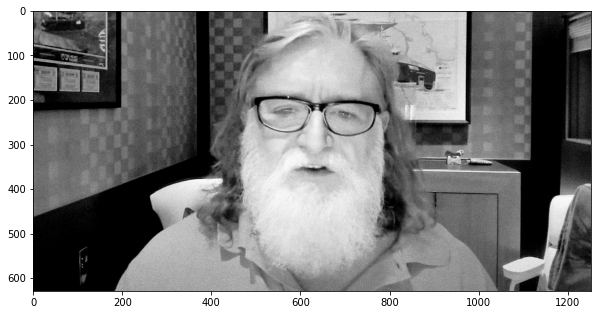

In [4]:
gray = grayscale(img)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot()
ax.imshow(gray, cmap='Greys_r')
plt.show()

3. Написать функцию реализации препарирования изображения

In [5]:
def prepping(img, func):
    prep = []
    for i in range(len(img)):
        prep.append([])
        for j in range(len(img[0])):
            prep[-1].append(func(img[i][j]))
    return prep

4. По гистограмме изображения определить значение порога яркостей, обеспечивающего оптимальное разделение объекта и фона. Осуществить пороговую обработку входного изображения с найденным пороговым значением

In [6]:
def make_hist(img, draw=False, rtrn = True):
    hist = []
    for i in range(256):
        hist.append(0)
    for i in range (len(img)):
        for j in range(len(img[0])):
            hist[img[i][j]] +=1
    if draw:
        plt.plot(hist)
        plt.show()
    if rtrn:
        return hist

def binary(img, t, draw=True):
    copy = np.array(img, copy=True)
    for i in range(len(copy)):
        for j in range(len(copy[0])):
            if copy[i][j] <= t:
                copy[i][j] = 0
            else:
                copy[i][j] = 255
    if draw:
        fig = plt.figure(figsize=(10,10))
        ax = fig.add_subplot()
        ax.imshow(copy, cmap='Greys_r')
        plt.show() 
    return copy

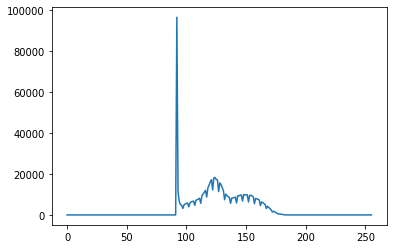

In [7]:
hist = make_hist(gray, draw=True)

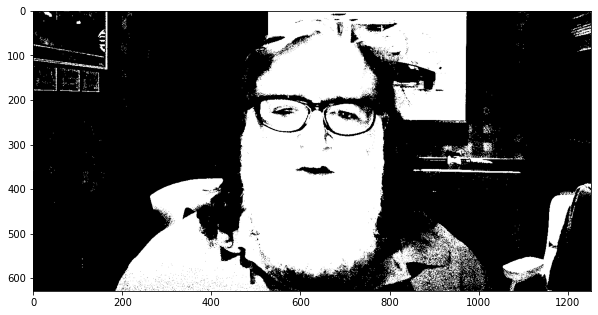

In [8]:
binary_own = binary(gray, 137)

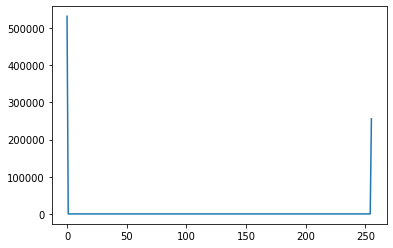

In [9]:
make_hist(binary_own, draw=True, rtrn=False)

5. Сделать пороговую обработку методом Otsu (Функция OpenCV)

In [10]:
def otsu(hist):
    S = sum(hist)
    y = 0
    for i in range(255):
        y+= hist[i]*i
    max_sigma = 0
    max_h = 0
    for h in range(1, 255):
        x = 0
        for i in range (h):
            x+=hist[i]*i
        m0 = x/sum(hist[:h]) if sum(hist[:h]) > 0 else 0.
        w0 = sum(hist[:h])/S
        m1 = y/sum(hist[h:]) if sum(hist[h:]) > 0 else 0.
        y-=hist[h]*h    
        w1 = sum(hist[h:])/S
        sigma = w0 * w1 * ((m0 - m1) ** 2)
        if sigma > max_sigma:
            max_sigma = sigma
            max_h = h
    return max_h

(<AxesSubplot:>, <matplotlib.image.AxesImage at 0x203e5ef6ac0>)

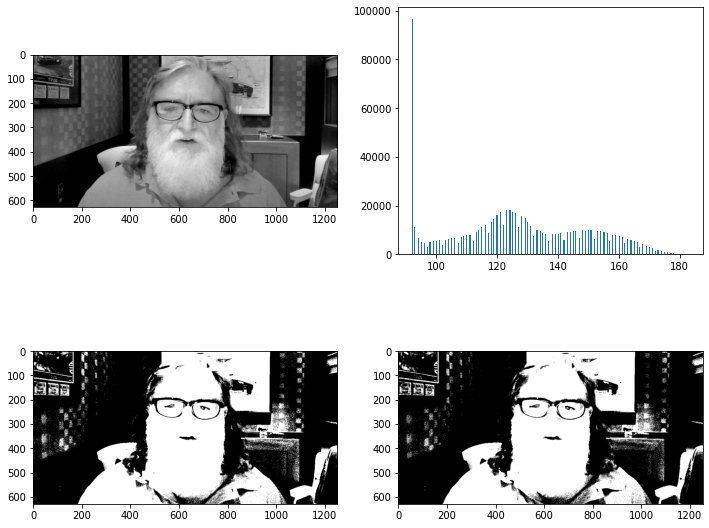

In [11]:
ret, th1 = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
th2 = binary(gray, otsu(hist), draw=False)
plt.figure(figsize=(12,10))
plt.subplot(221),plt.imshow(gray,'gray')
plt.subplot (222), plt.hist (gray.ravel (), 256)
plt.subplot(223),plt.imshow(th1,'gray')
plt.subplot(224),plt.imshow(th2,'gray')

Гисторграмма OpenCV реализации метода Otsu


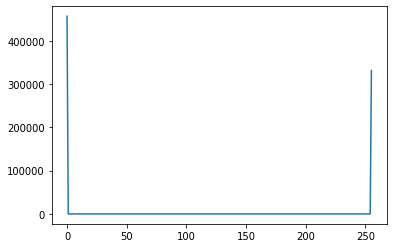

Гисторграмма ручной реализации метода Otsu


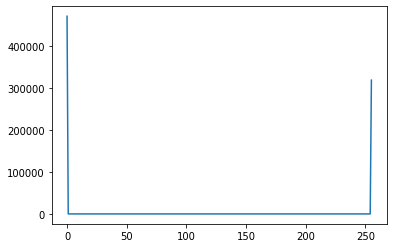

In [12]:
print("Гисторграмма OpenCV реализации метода Otsu")
make_hist(th1, draw=True, rtrn=False)
print("Гисторграмма ручной реализации метода Otsu")
make_hist(th2, draw=True, rtrn=False)

6. Определить динамический диапазон входного изображения. Осуществить линейное контрастирование входного изображения в заданный динамический диапазон яркостей

In [13]:
def find_edges(hist):
    for i in range(len(hist)-1):
        if hist[i] != 0:
            min = i
            break
    for i in range(len(hist)-1, 0, -1):
        if hist[i] != 0:
            max = i
            break
    return (min, max)

def line_contrasting(img):
    copy = np.array(img, copy=True)
    h = make_hist(img)
    min, max = find_edges(h)
    copy = (img-min)/(max-min)*255
    return copy.astype('uint8')

(<AxesSubplot:>, [<matplotlib.lines.Line2D at 0x203e63faa90>])

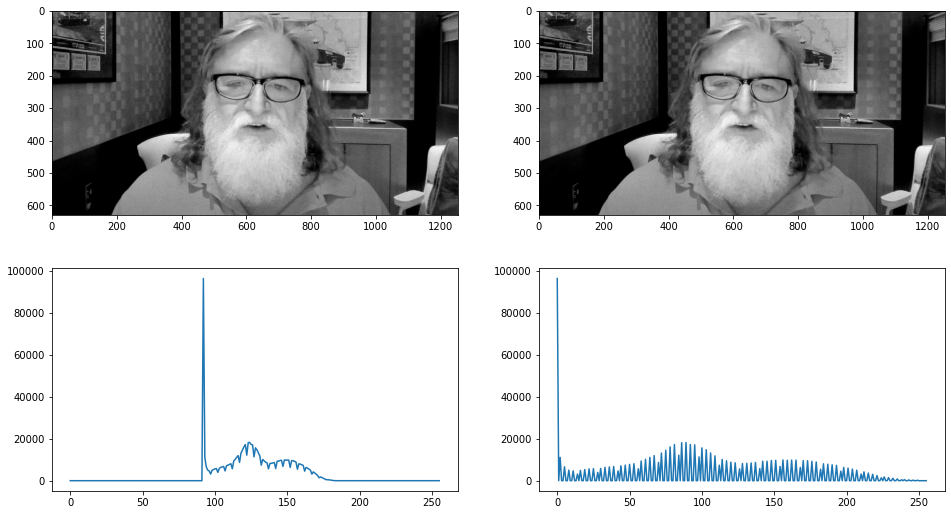

In [14]:
contr = line_contrasting(gray)
plt.figure(figsize=(16,9))
plt.subplot(221),plt.imshow(gray,'gray')
plt.subplot (222), plt.imshow(contr,'gray')
plt.subplot(223),plt.plot(make_hist(gray))
plt.subplot(224),plt.plot(make_hist(contr))

7. Сделать эквализацию гистограммы изображения

In [15]:

def equalize(hist):
    eq_hist = np.array(hist,copy=True)
    min, max = find_edges(hist)
    idxs = max-min+1
    sum_indxs = 0
    for i in range(0, idxs):
        sum_indxs+=i
    elements = sum(hist)
    for i in range(0,idxs):
        normal = i/sum_indxs*elements
        eq_hist[min+i] = (normal + hist[min+i])/2
    return eq_hist        

(<AxesSubplot:>, [<matplotlib.lines.Line2D at 0x203e29d9b50>])

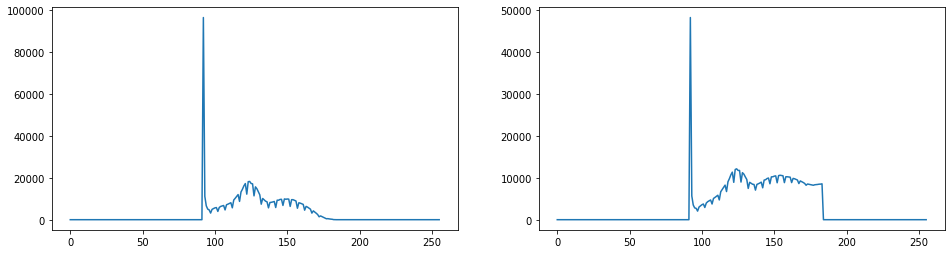

In [16]:
eq_hist = equalize(hist)
plt.figure(figsize=(16,9))
plt.subplot(221),plt.plot(hist)
plt.subplot(222),plt.plot(eq_hist)

8. Сделать эквализацию методом CLAHE (Функция OpenCV)

In [17]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))

In [18]:
import random
te = np.array(gray, copy=True)
te = sorted(te, key=lambda *args: random.random())
dst = clahe.apply(np.array(te))

(<AxesSubplot:>, [<matplotlib.lines.Line2D at 0x203e6462520>])

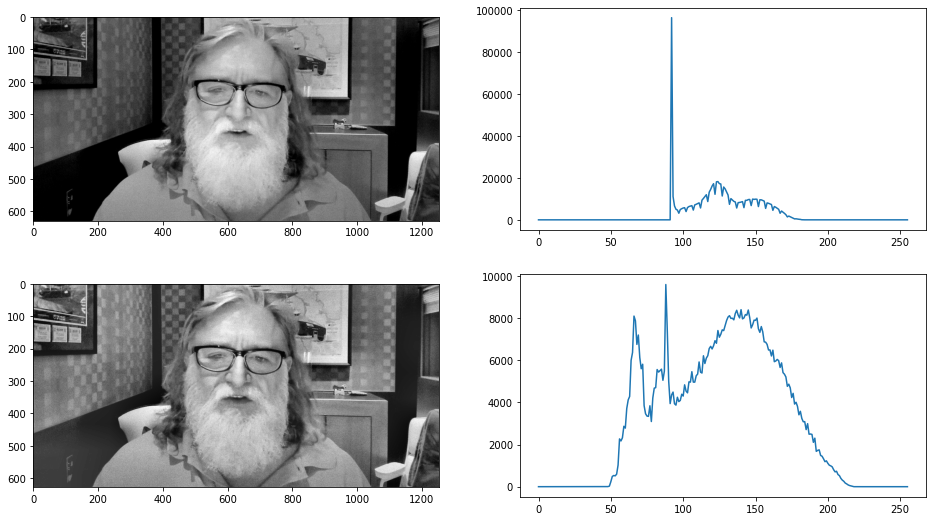

In [19]:
dsst_orig = clahe.apply(gray)
plt.figure(figsize=(16,9))
plt.subplot(221),plt.imshow(gray,'gray')
plt.subplot (222), plt.plot(make_hist(gray))
plt.subplot(223),plt.imshow(dsst_orig,'gray')
plt.subplot(224),plt.plot(make_hist(dsst_orig))

(<AxesSubplot:>, [<matplotlib.lines.Line2D at 0x203e6785a30>])

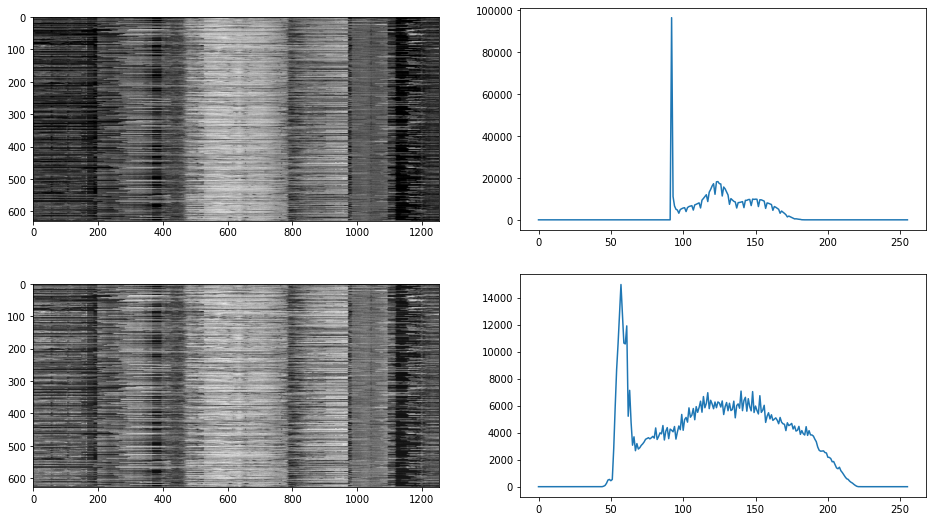

In [20]:
plt.figure(figsize=(16,9))
plt.subplot(221),plt.imshow(te,'gray')
plt.subplot (222), plt.plot(make_hist(te))
plt.subplot(223),plt.imshow(dst,'gray')
plt.subplot(224),plt.plot(make_hist(dst))

9. Осуществить препарирование изображения с заданной препарирующей функцией

In [27]:
def func3(x, t=140):
    y = x if x < t else 255.
    return (round(y))

prep = prepping(gray, func3)

(<AxesSubplot:>, [<matplotlib.lines.Line2D at 0x21935030dc0>])

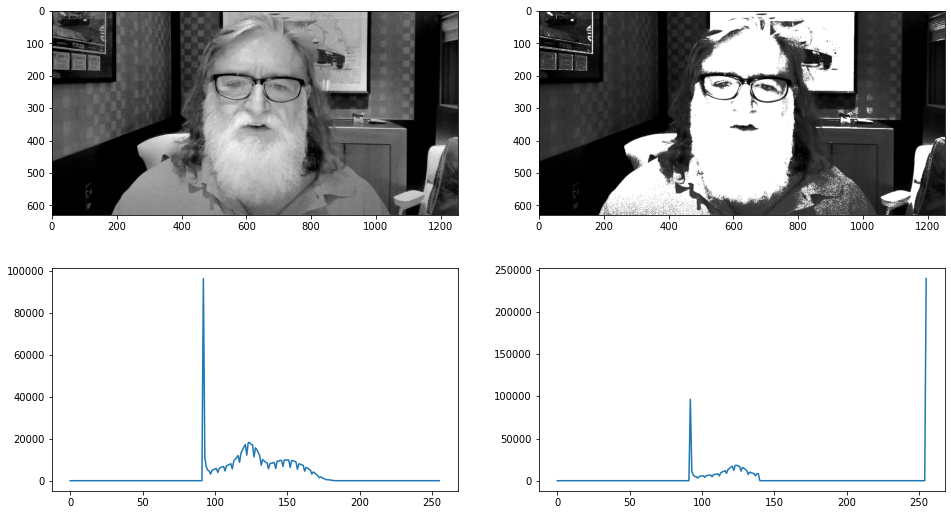

In [28]:
plt.figure(figsize=(16,9))
plt.subplot(221),plt.imshow(gray,'gray')
plt.subplot (222), plt.imshow(prep,'gray')
plt.subplot(223),plt.plot(make_hist(gray))
plt.subplot(224),plt.plot(make_hist(prep))